<span style="font-size: 14pt">MIPT, Applied ML, Autumn 2018</span>

<span style="font-size: 16pt"> Seminar #3: Compositions, NN, TS forecasting in Python

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

**Key words:** 
    - ARIMAX models, 
    - composition of forecasting algorigthms
    - NN for TS foreacasting

<h3> Plan </h3>
* **HW2 presentaion** (20 minutes)
* **Practice: realize compositions:** (20 minutes)</span> 
  - Adaptive Selection  
  - Adaptive Composition 
  - <span style="color:orange; font-size: 10pt"> Aggregating Algorithm </span> (self-study)
    
* **NN for forecasting energy consumption** (20 minutes)
  - Energy consumption data
  - NN with Keras,
  - Forecasting with Regression
  
* **TS Forecasting in Python** (20 minutes)
  - Facebook Prophet
  - Pyflux

In [4]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools

import warnings as w
from IPython.display import Image

%matplotlib inline

<h1 align="center"> HW1 solution </h1>

* Discuss Check Questions
* Forecasting with ARIMAX

<h1 align="center"> Practice: realize compositions</h1>
# Adaptive selection
** Question:**
* What is adaptive selection?
* Which external parameters does it have?
* Describe case when adaptive selection works bad.

In [ ]:
def adaptive_selection(x, h, params):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    params <dict> - dictionary with 
        gamma <scalar in [0,1]> - smoothing parameter of error
        eps <scalar> - bound for best indistinctive models
        base_algs - array of <dict> with params
            base_alg <string> - name of base algorithm
            BaseAlfParams <dict> dictionary of base algorithm's params
    '''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    
    
    # base algs Forecasts     
    base_algs = params['base_alg_params']
    N = len(base_algs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(N):
        FORECAST_BA[ba]= eval(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_algs_params'])")
        
    # internal params of composition
    gamma = params['gamma']
    eps = params['eps']
    
    if gamma>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if gamma<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST

    
    e1= np.zeros(N)  # initialization of errors of base algorithms 
    j_best = 0
    
    y=1.5
        
    for t in range(0, T):
        if not math.isnan(x[t]):
            
             if t>= h:
                'TODO: check this code'
                e1 = gamma*np.abs(x[t]-FORECAST_BA.transpose()[t])+(1-gamma)*e1  
           
                # select best algorithm at the moment t
                j_best = 'TODO: find index of best base alg'
                # select best indistinctive 
                idx_bestinsdistinctive = 'TODO: find indexes of best indistinctive algorithms'
    
                y = FORECAST_BA.transpose()[idx_bestinsdistinctive].mean()
                # else do nothing
#         else do nothing
            
            
        FORECAST[t+h] = y
    return FORECAST

In [4]:
base_algs = [{'base_alg':'InitExponentialSmoothing', 'base_algs_params':{'alpha':0.1, 'AdaptationPeriod':10}},
            {'base_alg':'AdaptiveExponentialSmoothing', 'base_algs_params':{'alpha':0.2,'gamma':0.01, 'AdaptationPeriod':10}}
#                  {'base_alg':'AdaptiveSimpleExponentialSmoothing', 'base_algs_params':{'alpha':0.1, 'gamma':0.01}},
#                 {'base_alg':'TheilWageSmoothing', 'base_algs_params':{'alpha':0.3, 'beta':0.9,'delta':0.9}}
]

In [5]:
for ba in range(len(base_algs)):
    print(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")

InitExponentialSmoothing(x,h,base_algs[0]['base_alg_params'])
AdaptiveExponentialSmoothing(x,h,base_algs[1]['base_alg_params'])


In [6]:
ts = pd.read_csv('https://raw.githubusercontent.com/ml-mipt/ml-mipt-part2/master/2017/seminars/1_ts_esm/data/TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
# ts = pd.read_csv('./data/TimeSeries_Data10.csv', sep=',', decimal='.')
ts = ts.sort_index() # sort index

In [7]:
h =1 
frc_ts = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h)))
                      , columns = ts.columns)

FRC_TS = dict()

In [35]:
# run Adaptive Selection
gamma=0.01
eps = 1.0
for cntr in ts.columns:
    frc_ts[cntr]= adaptive_selection(ts[cntr],h, {'gamma':gamma, 'eps': eps, 'base_alg_params':base_algs})
FRC_TS['AS gamma %.2f eps %.2f' % (gamma, eps)] = frc_ts

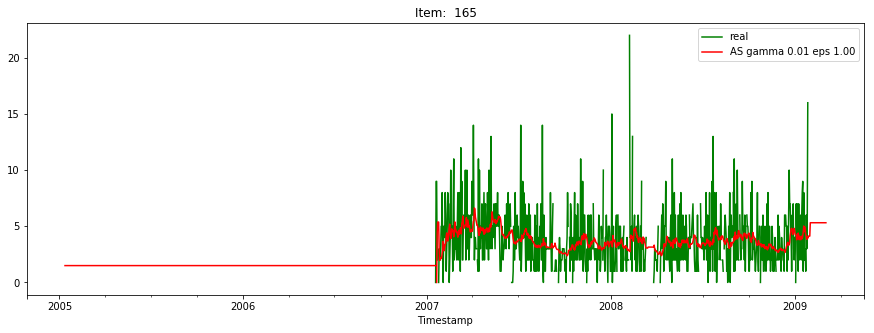

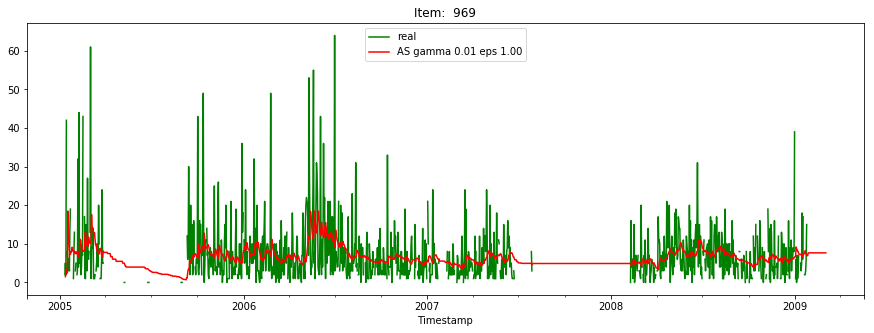

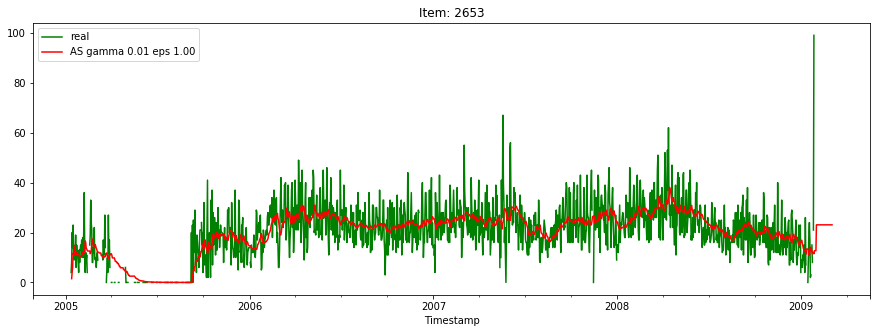

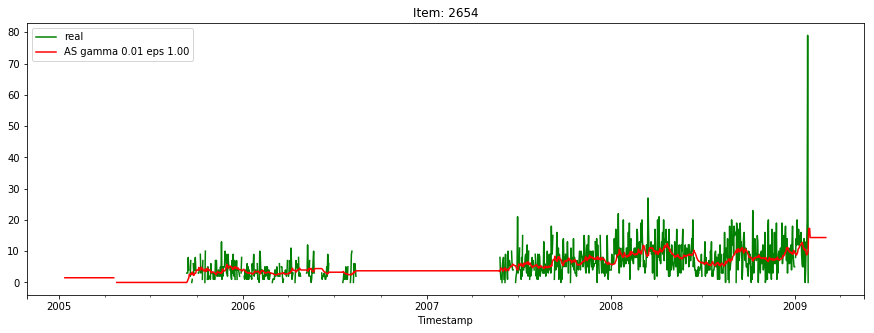

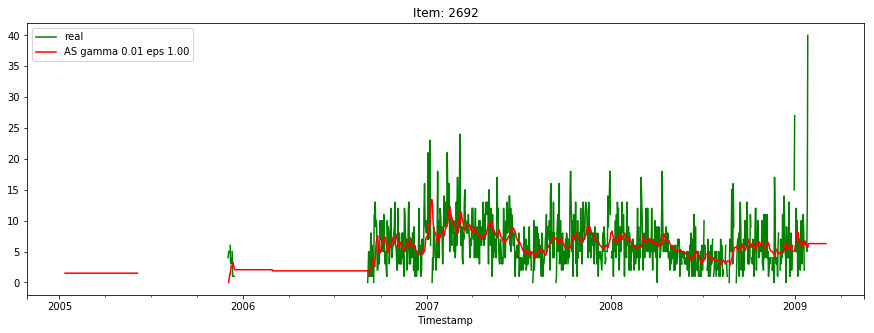

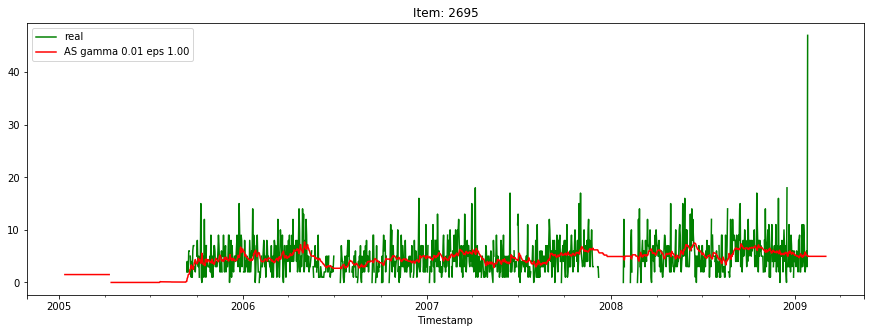

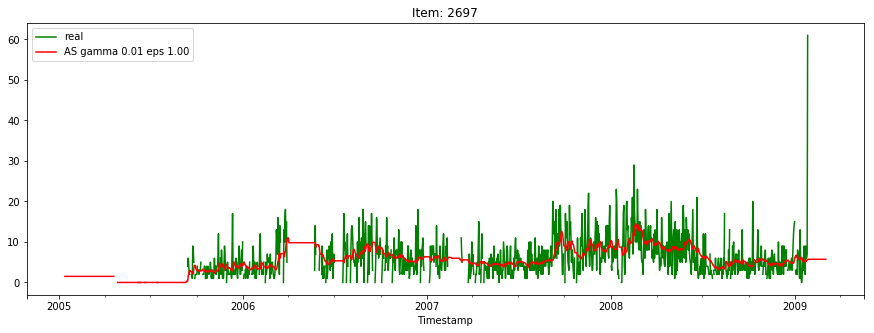

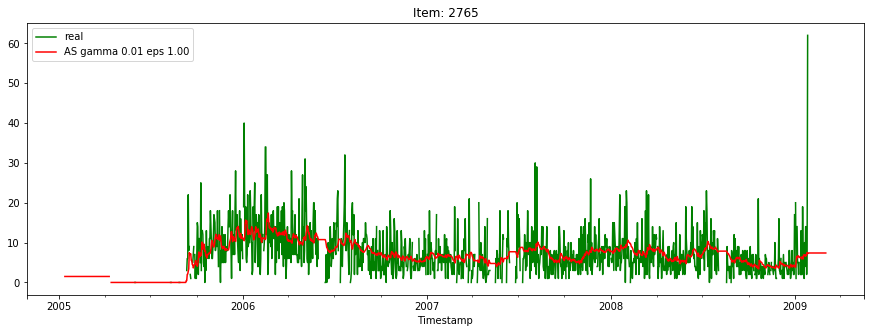

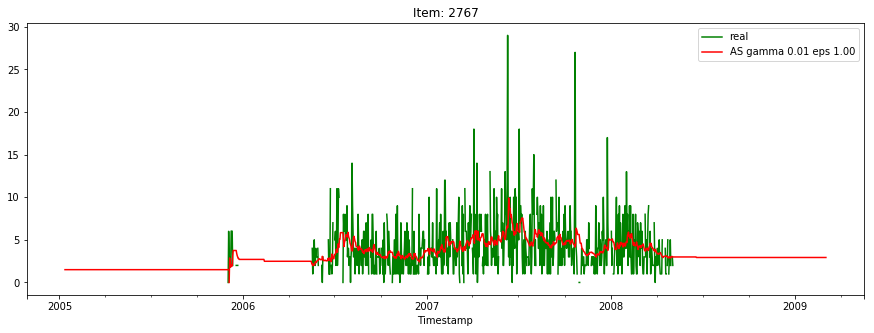

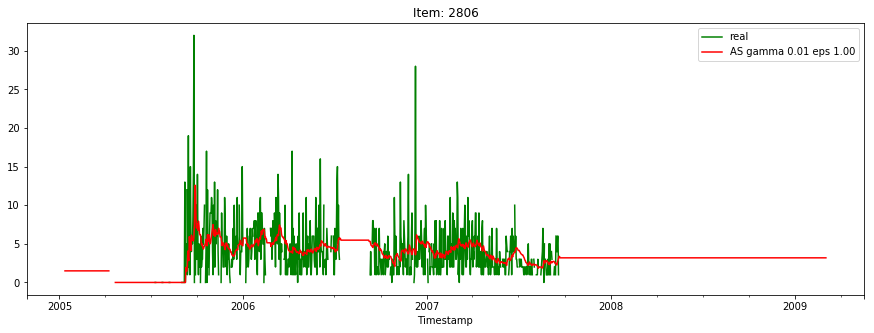

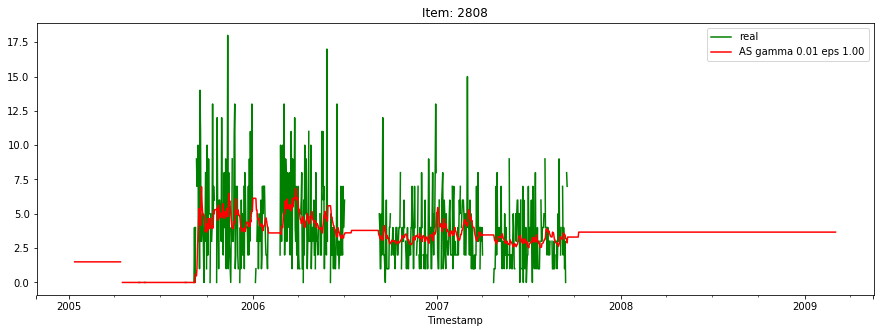

In [36]:
alg_name = 'AS gamma 0.01 eps 1.00'
for col in ts.columns:
    ts[col].plot(figsize=(15,5), color='green', label='real')
    forecast = FRC_TS[alg_name]
    forecast[col].plot(color='red', label=alg_name)
    plt.title(col)
    plt.legend()
    plt.show()

# Adaptive composition
** Question:**
* What is adaptive composition?
* Which external parameters does it have?
* Describe case when adaptive selection works 

In [ ]:
def adaptive_composition(x, h, params):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    params <dict> - dictionary with 
        gamma <scalar in [0,1]> - smoothing parameter of error
        base_algs - array of <dict> with params
            base_alg <string> - name of base algorithm
            base_alg_params <dict> dictionary of base algorithm's params
    '''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    
    
    # base algs Forecasts     
    base_algs = params['base_alg_params']
    N = len(base_algs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(len(base_algs)):
        FORECAST_BA[ba]= eval(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_algs_params'])")
    
    # internal params of composition
    gamma = params['gamma']
    
    if gamma>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if gamma<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST

    
    e1= np.array(np.ones(N))  # initialization of errors of base algorithms 
    weights = np.array(np.zeros(N))
    
    y=1.5
    
    for t in range(0, T):
        if not math.isnan(x[t]):
            
            if t>= h:
                e1 = gamma*np.abs(x[t]-FORECAST_BA.transpose()[t])+(1-gamma)*e1
           
                # select best algorithm at the moment t
                w_best = 'TODO: calculate weights of base algorithms'
                
#               Calculate forecast of the composition
                y = FORECAST_BA.transpose()[t].dot(weights)
                # else do nothing
#         else do nothing
            
            
        FORECAST[t+h] = y
    return FORECAST

In [37]:
# run Adaptive Composition
gamma=0.01
for cntr in ts.columns:
    frc_ts[cntr]= adaptive_composition(ts[cntr],h, {'gamma':gamma, 'base_alg_params':base_algs})
FRC_TS['AC gamma %.2f' % (gamma)] = frc_ts

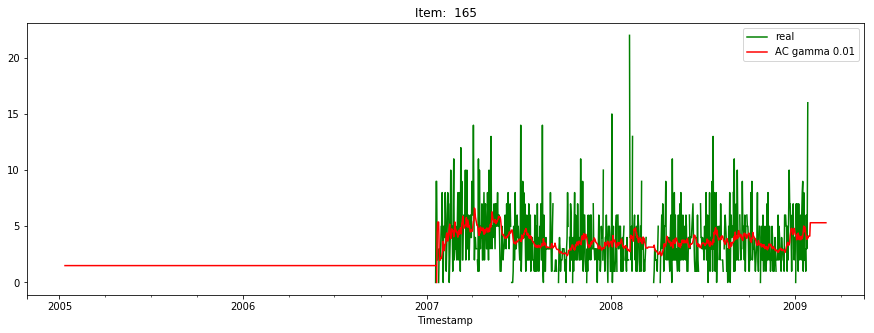

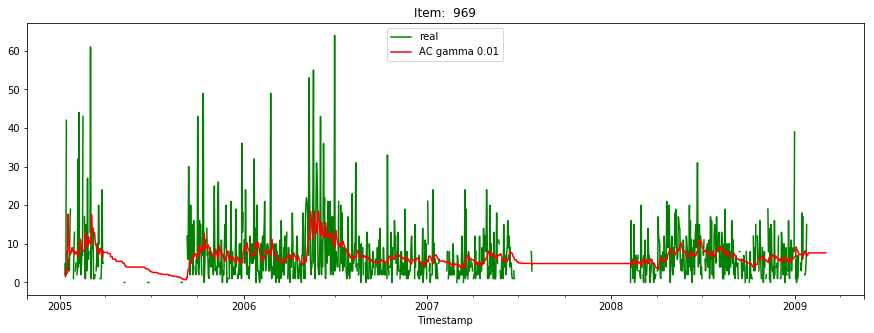

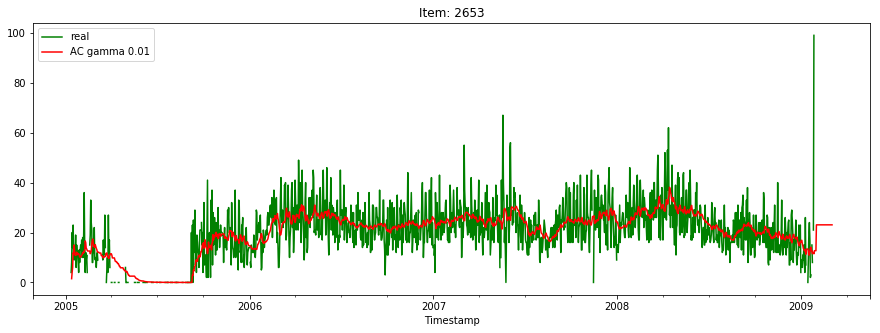

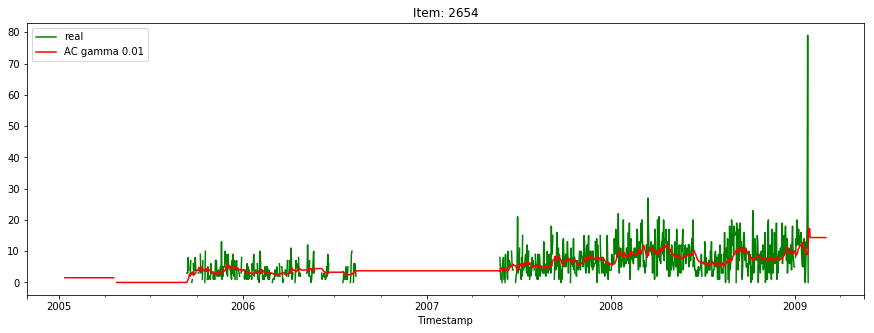

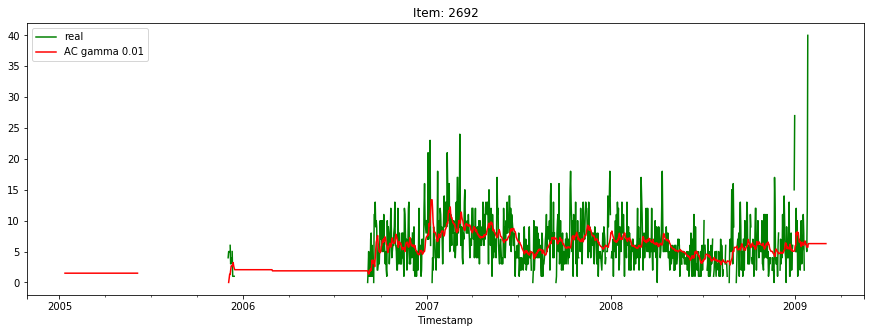

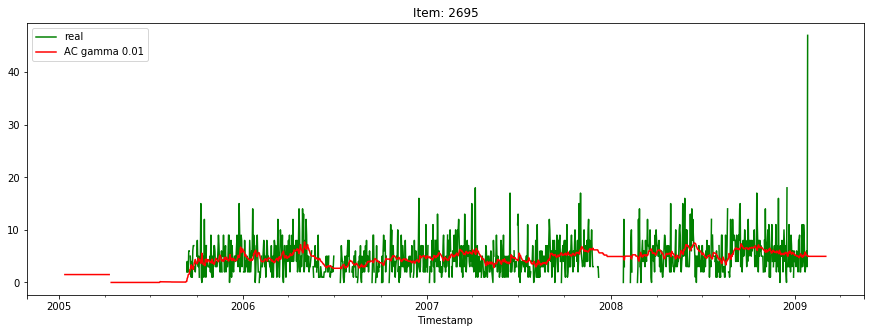

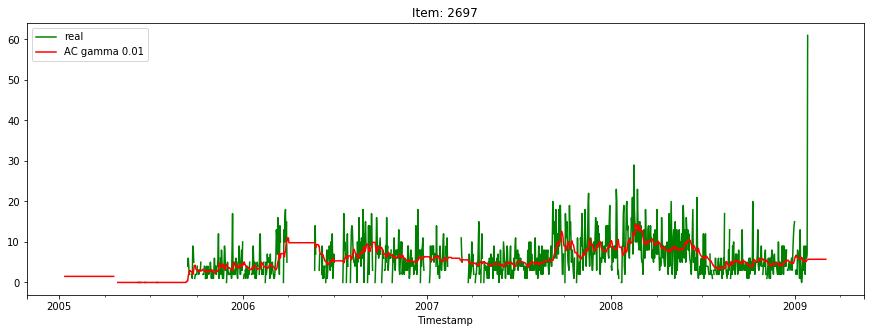

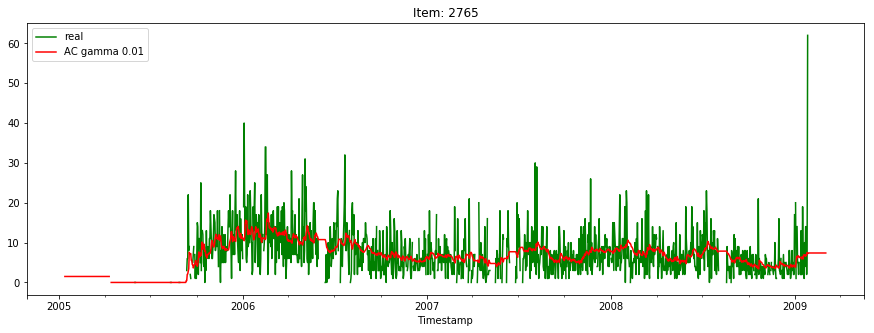

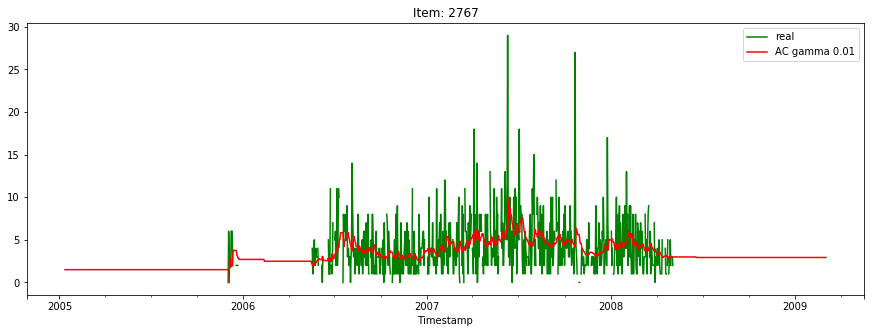

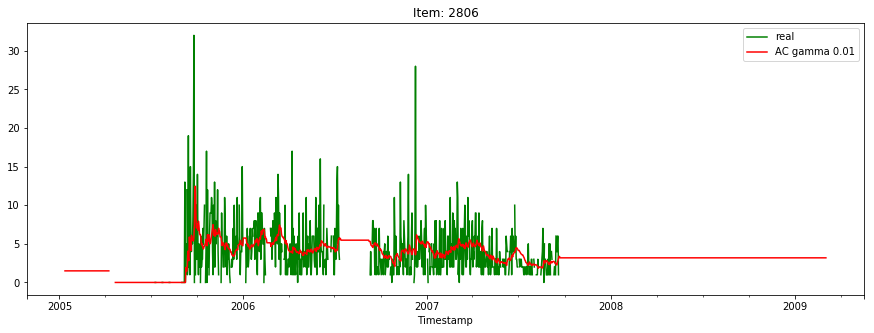

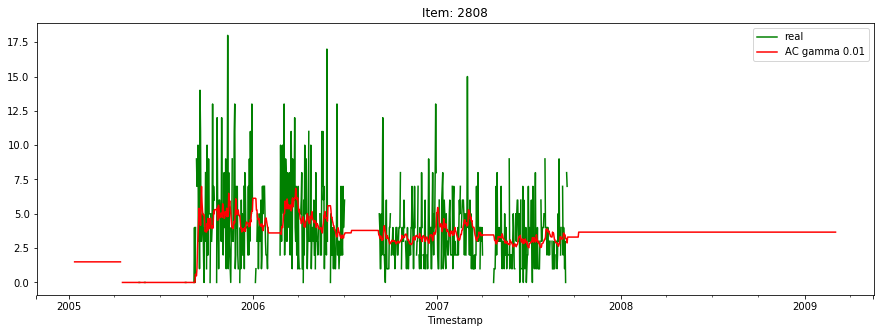

In [38]:
alg_name = 'AC gamma 0.01'
for col in ts.columns:
    ts[col].plot(figsize=(15,5), color='green', label='real')
    forecast = FRC_TS[alg_name]
    forecast[col].plot(color='red', label=alg_name)
    plt.title(col)
    plt.legend()
    plt.show()

# Aggregating Algorithm (self study)
** Question:**
* What is aggregating algorithm?
* Descibe parameters of AA:
    - $\beta$ - parametr of mixability
    - $S(g)$ - substitution function
    - $p_j$ - initial distribution of base algorithms
* Write down theoretical boundary for AA

In [ ]:
def aa_composition(x, h, params):
'''
Parameters
x <array> - time series
h <integer scalar>- forecasting delay
params <dict> - dictionary with 
    beta <scalar in [0,1]> - mixability parameter 
    weights <array in [0,1]> - initial weights of base_algs
    base_algs - array of <dict> with params
        base_alg <string> - name of base algorithm
        base_alg_params <dict> dictionary of base algorithm's params
'''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    
    
    # Base Algs Forecasts     
    base_algs = params.base_algs
    N = len(base_algs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(len(base_algs)):
        FORECAST_BA[BA]= eval(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")
    
    # internal params of composition
    beta = params['beta']
    weights = params['weights']
    
    if beta>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if beta<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST

           
    for t in range(0, T):
        if not math.isnan(x[t]):
            
            if t>= h:
                weights = 'TODO: update weights'
           
                
#               Calculate forecast of the composition
                y = 'Substitution function'
                
         else:
            y = 'Substitution function'
            
        FORECAST[t+h] = y
    return FORECAST

In [ ]:
h =1 
base_algs = [{'base_alg':'InitExponentialSmoothing', 'base_alg_params':{'alpha':0.1, 'AdaptationPeriod':10}},
            {'base_alg':'AdaptiveExponentialSmoothing', 'base_alg_params':{'alpha':0.2,'gamma':0.01, 'AdaptationPeriod':10}}
frc_ts = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h)))
                      , columns = ts.columns)
FRC_TS = dict()

for cntr in ts.columns:
    frc_ts[cntr]= aa_composition(ts[cntr],h, {'beta':0.9, 'weiths': np.array([0.5,0.5]), 'base_alg_params':base_algs})
FRC_TS['AA beta %.2f' % (beta)] = frc_ts

<h1 align="center"> TS forecasting with NN </h1>

See [Keras_for_tsforecasting.ipynb](https://github.com/ml-mipt/ml-mipt-part2/blob/master/2018/seminars/3_advanced_forecasting/Keras_for_tsforecasting.ipynb)

---
<h1 align="center"> TS forecasting in Python </h1>
# Facebook Prophet

In [6]:
from fbprophet import Prophet

In [7]:
## Wage
ts_wage = pd.read_csv('https://raw.githubusercontent.com/ml-mipt/ml-mipt-part2/master/2017/seminars/1_ts_esm/data/monthly-wage.csv', sep=';', decimal='.', parse_dates=True, index_col='Month')
ts_wage.index.names=['Timestamp']
# ts = pd.read_csv('./data/TimeSeries_Data10.csv', sep=',', decimal='.')
ts_wage = ts_wage.sort_index() # sort index
ts_wage.head()

,Real wage
Timestamp,
1993-01-01,100.00
1993-02-01,99.04
1993-03-01,101.77
1993-04-01,110.05
1993-05-01,115.47


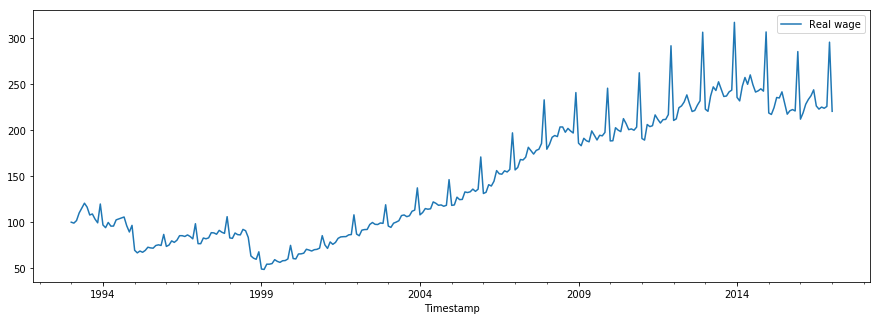

In [9]:
ts_wage.plot(figsize=(15,5))

In [69]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
fb_model = Prophet(interval_width=0.95)

In [70]:
# transform ts for fbprophet
ts_wage.reset_index(inplace=True)
ts_wage.rename(index=str, columns={'Real wage':'y', 'Timestamp':'ds'}, inplace=True)
ts_wage.head()

# fit model
fb_model.fit(ts_wage)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [71]:
future_dates = fb_model.make_future_dataframe(periods=12, freq='MS')
future_dates.tail()

,ds
296,2017-09-01
297,2017-10-01
298,2017-11-01
299,2017-12-01
300,2018-01-01


In [72]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1993-01-01,105.240652,73.049420,117.551919,105.240652,105.240652,-9.501137,-9.501137,-9.501137,-9.501137,-9.501137,-9.501137,0.0,0.0,0.0,95.739515
1,1993-02-01,104.686492,72.482348,114.535891,104.686492,104.686492,-11.078244,-11.078244,-11.078244,-11.078244,-11.078244,-11.078244,0.0,0.0,0.0,93.608248
2,1993-03-01,104.185961,80.541398,122.759934,104.185961,104.185961,-3.043085,-3.043085,-3.043085,-3.043085,-3.043085,-3.043085,0.0,0.0,0.0,101.142877
3,1993-04-01,103.631802,79.704964,121.863646,103.631802,103.631802,-2.349496,-2.349496,-2.349496,-2.349496,-2.349496,-2.349496,0.0,0.0,0.0,101.282306
4,1993-05-01,103.095519,80.745104,123.863798,103.095519,103.095519,-1.912809,-1.912809,-1.912809,-1.912809,-1.912809,-1.912809,0.0,0.0,0.0,101.182709


In [73]:
forecast = fb_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
296,2017-09-01,241.746257,219.848062,263.553496
297,2017-10-01,240.993468,219.989669,263.546718
298,2017-11-01,241.236964,218.769904,262.635573
299,2017-12-01,278.729557,257.132242,299.801491
300,2018-01-01,234.914437,212.433661,256.033225


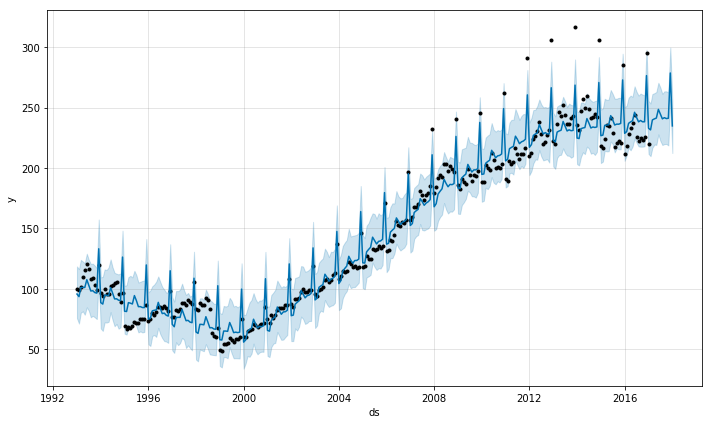

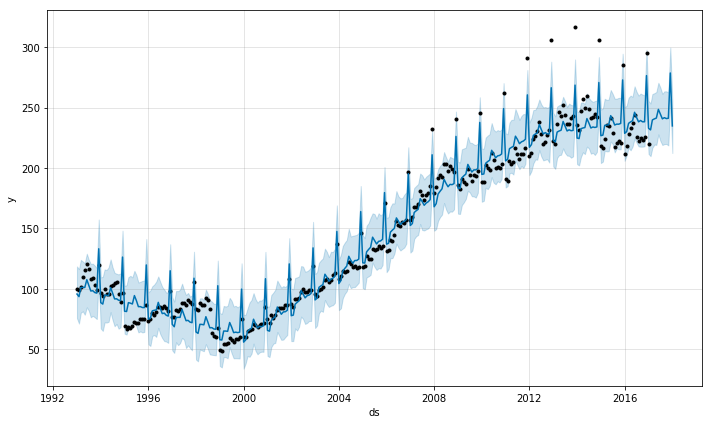

In [75]:
# plot forecast with confidence interval
fb_model.plot(forecast)

# Pyflux
https://pyflux.readthedocs.io/en/latest/index.html

In [ ]:
import pyflux as pf

## ARIMA

In [36]:
ts_wage = ts_wage.set_index('ds')[['y']].sort_index() # sort index
ts_wage.head()

,y
ds,
1993-01-01,100.00
1993-02-01,99.04
1993-03-01,101.77
1993-04-01,110.05
1993-05-01,115.47


In [64]:
# can fit parameters about for any models because has regularization
pf_arima = pf.ARIMA(data=ts_wage, ar=4, ma=4, integ = 1, target='y', family=pf.Normal())
x = pf_arima.fit("MLE")
x.summary()

Normal ARIMA(4,1,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced y                       Method: MLE                                       
Start Date: 1993-05-01 00:00:00                         Log Likelihood: -1123.7226                        
End Date: 2017-01-01 00:00:00                           AIC: 2267.4452                                    
Number of observations: 284                             BIC: 2303.935                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.8012     0.5795     1.3827   0.1668   (-0.3345 | 1.9369)       
AR(1)                                

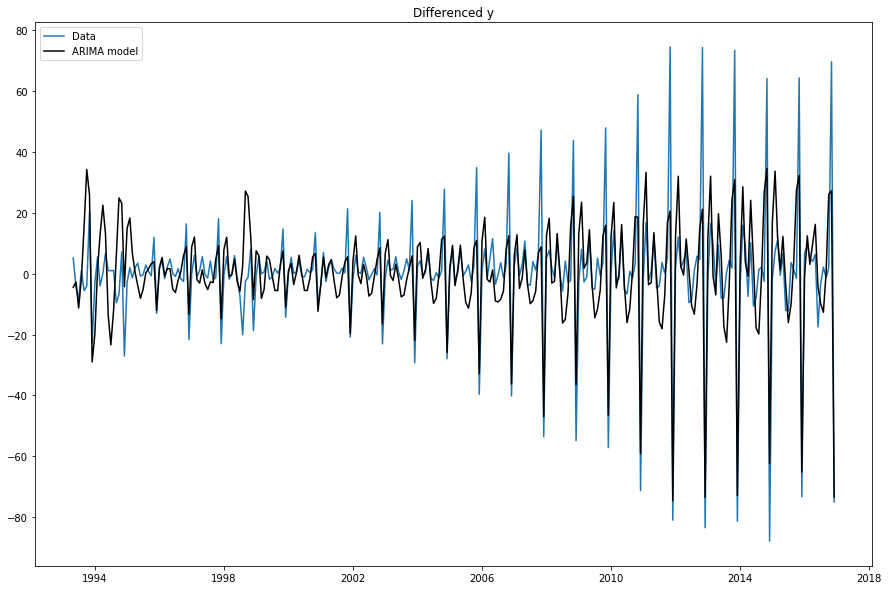

In [65]:
pf_arima.plot_fit(figsize=(15,10))

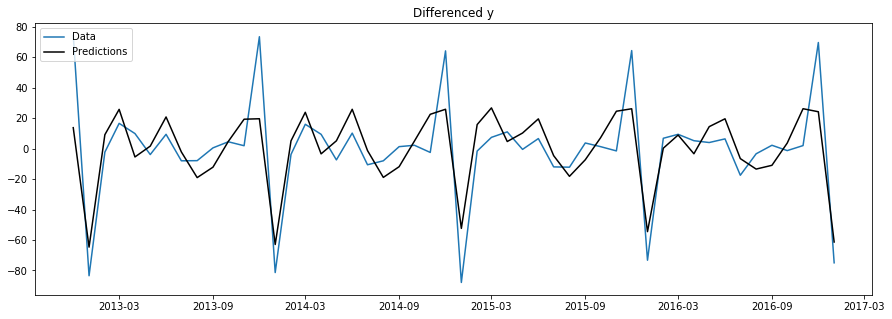

In [66]:
# in-rolling prediction
# Only for defferenced TS
pf_arima.plot_predict_is(h=50, figsize=(15,5))

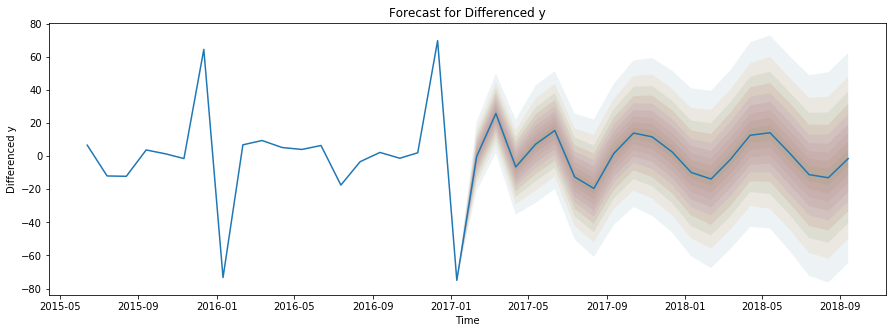

In [67]:
# plot future prediction
pf_arima.plot_predict(h=20,past_values=20,figsize=(15,5))

## ARIMAX

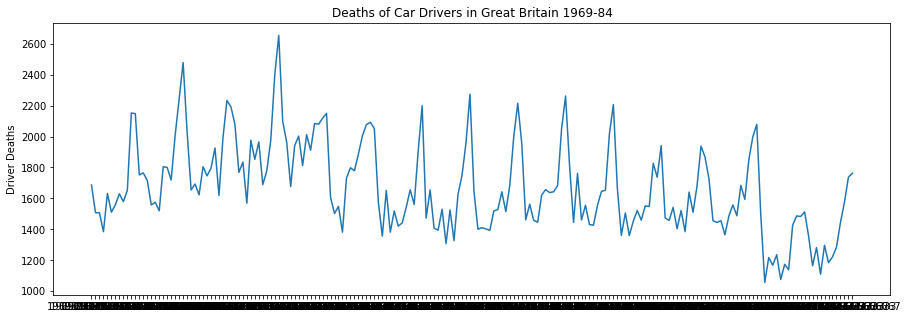

In [51]:
data = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/MASS/drivers.csv")
data.index = data['time'];
data.rename(index=str, columns={'value':'drivers'}, inplace=True)
data.loc[(data['time']>=1983.05), 'seat_belt'] = 1;
data.loc[(data['time']<1983.05), 'seat_belt'] = 0;
data.loc[(data['time']>=1974.00), 'oil_crisis'] = 1;
data.loc[(data['time']<1974.00), 'oil_crisis'] = 0;
plt.figure(figsize=(15,5));
plt.plot(data.index,data['drivers']);
plt.ylabel('Driver Deaths');
plt.title('Deaths of Car Drivers in Great Britain 1969-84');

In [52]:
pf_arimax = pf.ARIMAX(data=data, formula='drivers~1+seat_belt+oil_crisis',
                  ar=1, ma=1, family=pf.Normal())
x = pf_arimax.fit("MLE")
x.summary()

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: drivers                             Method: MLE                                       
Start Date: 1969.08333333333                            Log Likelihood: -1278.7663                        
End Date: 1984.91666666667                              AIC: 2569.5327                                    
Number of observations: 191                             BIC: 2589.0463                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.5003     0.0933     5.3615   0.0      (0.3174 | 0.6831)        
MA(1)                                

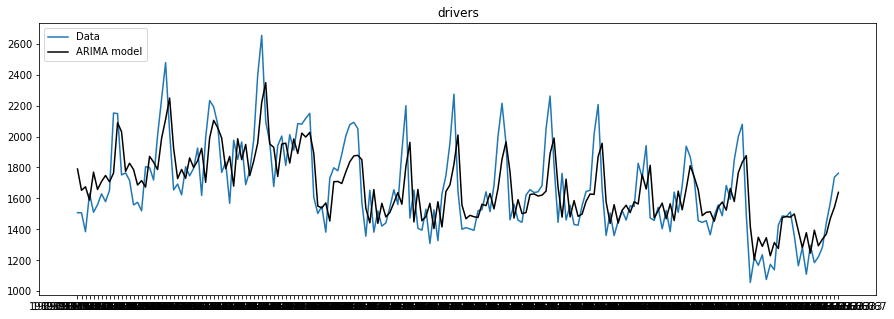

In [53]:
# plot model forecast vs TS
pf_arimax.plot_fit(figsize=(15,5))

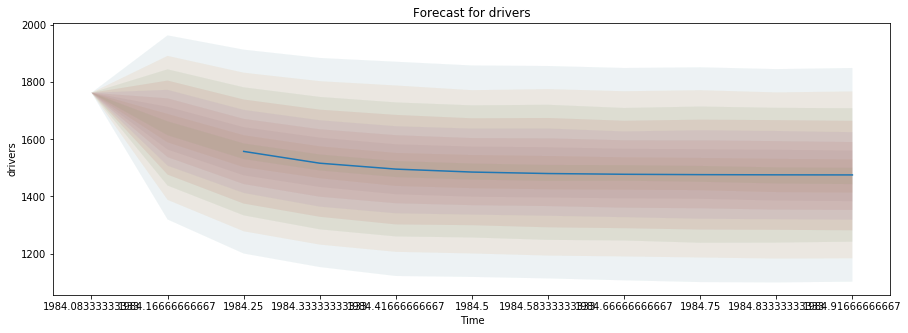

In [54]:
# plot prediction
pf_arimax.plot_predict(h=10, oos_data=data.iloc[-12:], past_values=0, figsize=(15,5))
# model.plot_predict(h=20,past_values=20,figsize=(15,5))

# Other TS forecasting frameworks for Python
    - http://rpy2.bitbucket.org/

<h1 align="center"> Conclusion </h1>

  * оцените <a href="https://goo.gl/forms/zSEynRUOCIO1SXv02"> семинар </a>